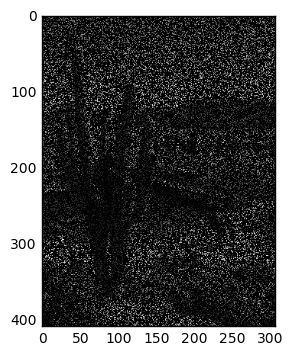

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img_origin = cv2.imread('./image/A.png')
b,g,r = cv2.split(img_origin)
img_origin = cv2.merge([r,g,b])
plt.imshow(img_origin)

### 加上噪声

In [ ]:
# import random

dimension = len(img.shape)
print(dimension)
nrows = img.shape[0]
ncols = img.shape[1]
percent = 0.8

img_damaged = img.copy()

for row in range(nrows):
    choices = random.sample(range(ncols), int(percent * ncols))    
    for col in choices:
        # 黑白
        if dimension == 2:
            img_damaged[row][col] = 0
        # 彩色
        if dimension == 3:
            img_damaged[row][col] = [0, 0, 0]

io.imshow(img_damaged)

### 获取噪声mask

In [3]:
mask = []
if dimension == 2:
    for row in range(nrows):
        t = [1 if img_damaged[row][col] != 0 else 0 for col in range(ncols)]
        mask.append(t)
if dimension == 3:
    for row in range(nrows):
        t = [1 if (img_damaged[row][col][0] != 0 and img_damaged[row][col][1] != 0 and img_damaged[row][col][2] != 0) else 0 for col in range(ncols)]
        mask.append(t)

### 利用cvxpy解决图像凸优化

In [4]:
# from cvxpy import *
# variables = []
# constr = []
# for i in range(3):
#     X = Variable((nrows, ncols))
#     variables += [X]
#     print(variables)
#     constr += [(K*(X - img_damaged[:, :, i])) == 0]

# prob = Problem(Minimize(tv(*variables)), constr)
# prob.solve(solver=SCS)
# import numpy as np
# import matplotlib.pyplot as plt
# X_rec = np.zeros((nrows, ncols, 3))
# for i, var in enumerate(variables):
#     X_rec[:,:,i] = var.value
# print(X_rec)
# plt.imshow(X_rec)

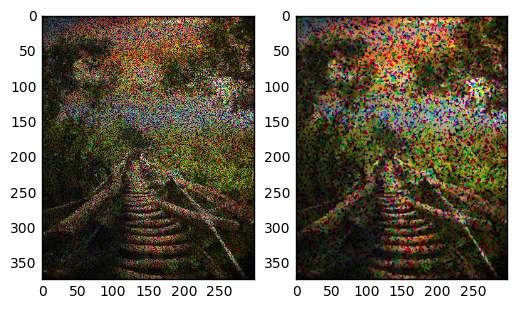

In [84]:
img_medianBlur = cv2.medianBlur(img_origin, 3)
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(img_medianBlur)
plt.show()

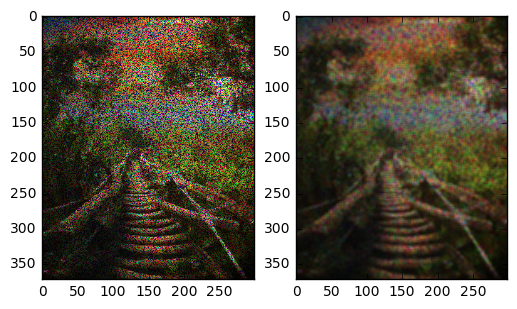

In [83]:
img_blur=cv2.blur(img_origin,(5, 5))
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(img_blur)
plt.show()

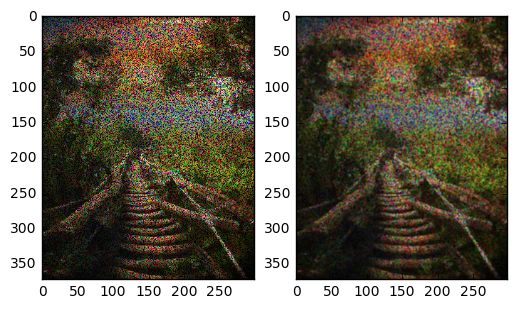

In [82]:
img_gaussianBlur=cv2.GaussianBlur(img_origin,(3,3),0)
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(img_gaussianBlur)
plt.show()

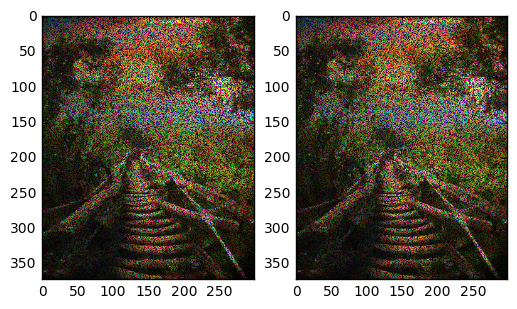

In [81]:
img_bilateral=cv2.bilateralFilter(img_origin,10,10,30)
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(img_bilateral)
plt.show()

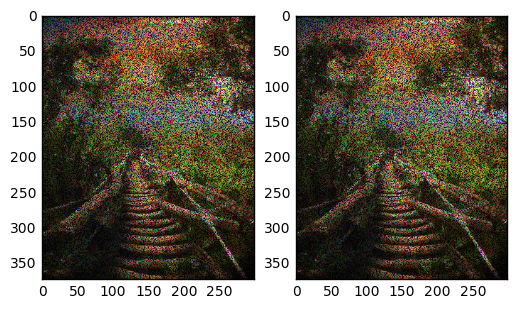

In [80]:
img_NLmeans = cv2.fastNlMeansDenoisingColored(img_origin,None,10,10,7,21)
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(img_NLmeans)
plt.show()

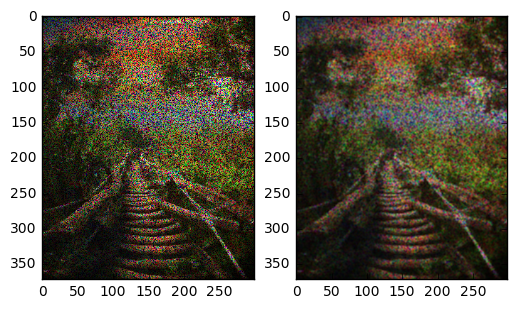

In [86]:
def ArithmeticMeanOperator(roi):
    return np.mean(roi)
def ArithmeticMeanAlogrithm(image):
    new_image = np.zeros(image.shape)
    image = cv2.copyMakeBorder(image,1,1,1,1,cv2.BORDER_DEFAULT)
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            new_image[i-1,j-1] = ArithmeticMeanOperator(image[i-1:i+2,j-1:j+2])
    new_image = (new_image-np.min(image))*(255/np.max(image))
    return new_image.astype(np.uint8)
def rgbArithmeticMean(image):
    r,g,b = cv2.split(image)
    r = ArithmeticMeanAlogrithm(r)
    g = ArithmeticMeanAlogrithm(g)
    b = ArithmeticMeanAlogrithm(b)
    return cv2.merge([r,g,b])
plt.subplot(121),plt.imshow(img_origin)
plt.subplot(122),plt.imshow(rgbArithmeticMean(img_origin))
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
D:\tools\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars


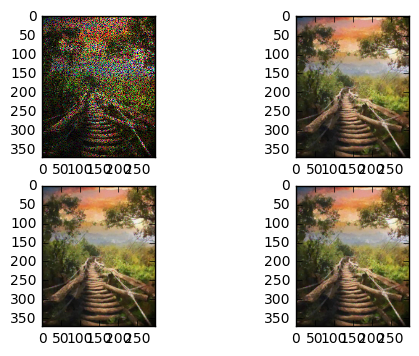

True

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_noise = cv2.imread('./image/B.png')
b, g, r = cv2.split(img_noise)
img_noise = cv2.merge([r, g, b])

mask = []
for row in range(img_noise.shape[0]):
    line_mask = []
    for col in range(img_noise.shape[1]):
        if img_noise[row][col][0] != 0 or img_noise[row][col][1] != 0 or img_noise[row][col][2] != 0:
            line_mask.append(1)
        else:
            line_mask.append(0)
    mask.append(line_mask)


def IHMeanMask(image):
    img_mask = image.copy()
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if mask[row][col] == 1:
                img_mask[row][col] = img_noise[row][col]
            else:
                pass
    return img_mask

def IHMeanOperator(roi, q):
    roi = roi.astype(np.float64)
    return np.mean((roi)**(q+1))/np.mean((roi)**(q))

def IHMeanFilter(image, q):
    image_filter = np.zeros(image.shape)
    image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            image_filter[i-1, j-1] = IHMeanOperator(image[i-1:i+2, j-1:j+2], q)
    image_filter = (image_filter-np.min(image))*(255/np.max(image))
    return image_filter.astype(np.uint8)


def IHMean(image, q):
    r, g, b = cv2.split(image)
    r = IHMeanFilter(r, q)
    g = IHMeanFilter(g, q)
    b = IHMeanFilter(b, q)
    return cv2.merge([r, g, b])


def IHMeanEpoch(img_IHMean):
    img_IHMean = IHMeanMask(img_IHMean)
    img_IHMean = IHMean(img_IHMean, 0.1)
    return img_IHMean


plt.subplot(221), plt.imshow(img_noise)
img_IHMean = IHMean(img_noise, 0.1)
plt.subplot(222), plt.imshow(img_IHMean)
img_IHMean = IHMeanEpoch(img_IHMean)
plt.subplot(223), plt.imshow(img_IHMean)
for i in range(3):
    img_IHMean = IHMeanEpoch(img_IHMean)
plt.subplot(224), plt.imshow(img_IHMean)
plt.show()
r, g, b = cv2.split(img_IHMean)
img_IHMean = cv2.merge([b, g, r])
cv2.imwrite("1.png", img_IHMean)
